In [1]:
import os
import gc
import pickle
import gzip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from model import ViTBackbone, SegmentationModel, interpolate_pos_embed
from util import *

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import albumentations as A
from torchvision.transforms import InterpolationMode

In [2]:
ckpt_path = "output/finetune/FT-sz512-lr0.0003-ep200-wd0.001/FT-sz512-lr0.0003-ep200-wd0.001.ckpt"
ckpt = torch.load(ckpt_path)
model_ckpt = {}
for k, v in ckpt["state_dict"].items():
    new_k = k.replace("model.", "")
    
    if "mask" in new_k or "decoder" in new_k:
        continue
        
    model_ckpt[new_k] = v

In [3]:
img_size=512
patch_size=16
embed_dim=768
depth=12
num_heads=12
mlp_ratio=4

In [5]:
vit_backbone = ViTBackbone(
    img_size=img_size,
    in_chans=1,
    patch_size=patch_size, 
    embed_dim=embed_dim, 
    depth=depth, 
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    drop_path=0.1,
)

model = SegmentationModel(vit_backbone)
model = model.cuda()
interpolate_pos_embed(model, model_ckpt, 'pos_embed')
interpolate_pos_embed(model, model_ckpt, 'vit_backbone.pos_embed')
model.load_state_dict(model_ckpt)

<All keys matched successfully>

In [6]:
test_data = load_zipped_pickle("data/test.pkl")
samples = load_zipped_pickle("data/sample.pkl")

In [8]:
class MAEDataset(Dataset):
    def __init__(self, video, transform):
        super().__init__()
        self.video = video
        self.transform = transform
        
    def __len__(self):
        return self.video.shape[2]
    
    def __getitem__(self, i):
        frame = self.video[:, :, i]
        frame = frame.astype(np.uint8)
        transformed = self.transform(image=frame)
        img = torch.tensor(transformed["image"] / 255, dtype=torch.float32)
        img = img.unsqueeze(0)
        return img
    
@torch.inference_mode()
def predict(model, item, thres):
    model.eval()
    name = item["name"]
    video = item["video"]
    H, W, L = video.shape
    
    test_ds = MAEDataset(
        video=video,
        transform=A.Compose([
            A.Resize(
                height=img_size,
                width=img_size,
                interpolation=cv2.INTER_LINEAR,
            )
        ])
    )
    
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)
    logits = []
    for x in test_loader:
        x = x.cuda()
        logits.append(model(x).cpu())
    
    logits = torch.vstack(logits)
    logits = F.interpolate(logits, (H, W), mode='bilinear', align_corners=False)
    out = torch.sigmoid(logits).squeeze() # Shape (L, H, W)
    mask = out > thres
    out[mask] = 1.0
    out[~mask] = 0.0
    out = torch.einsum('lhw->hwl', out)
    out = out.numpy()
    assert out.shape == video.shape
    return {
        "name": name,
        "prediction": out.astype("bool")
    }

In [9]:
import pickle
import gzip
from tqdm import tqdm

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
        
predictions = []
for x in tqdm(test_data):
    out = predict(model, x, thres=0.85)
    predictions.append(out)

save_zipped_pickle(predictions, "fun.pkl")

100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


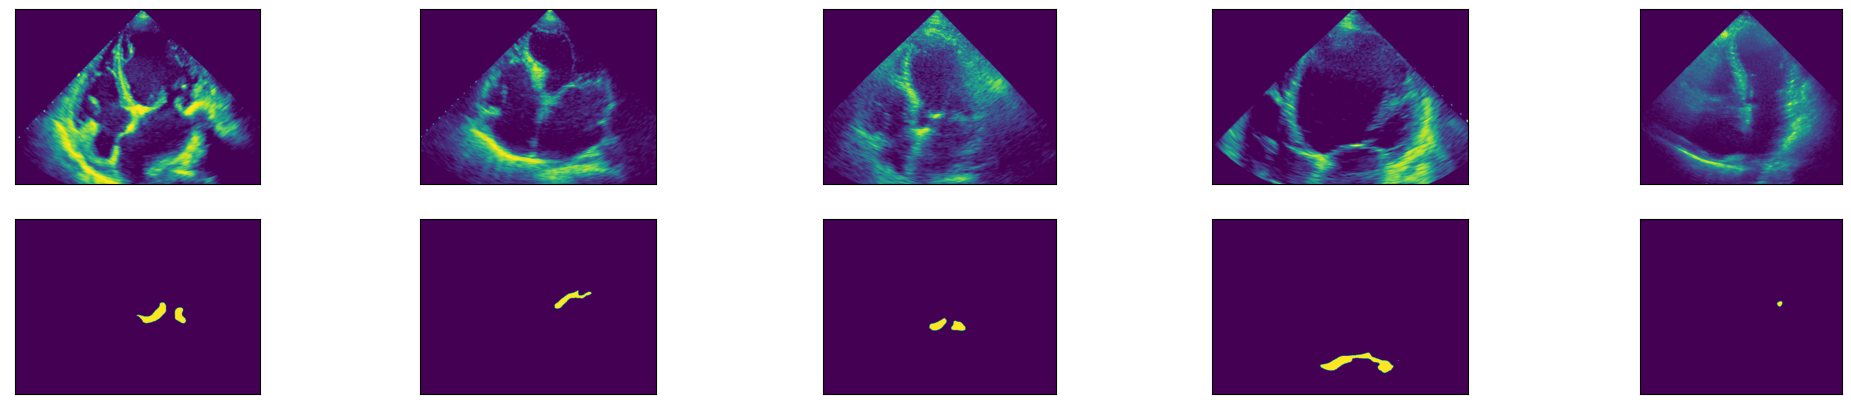

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

to_img = lambda x: Image.fromarray(x.astype(np.uint8)).convert("L")

fig, ax = plt.subplots(2, 5, figsize=(25, 5))
for i in range(5):
    name = test_data[i]["name"]
    video = test_data[i]["video"]
    pred = predictions[i]["prediction"]
    H, W, L = video.shape
    k = 0
    frame = video[:, :, k]
    mask = pred[:, :, k]
    ax[0, i].imshow(to_img(frame))
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow(to_img(mask))
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])